In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE


In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('Alzheimer_s Dataset')):
    subfolder_path = os.path.join('Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 40.00it/s]


,image,label
0,Alzheimer_s Dataset\test\MildDemented\26 (19).jpg,MildDemented
1,Alzheimer_s Dataset\test\MildDemented\26 (20).jpg,MildDemented
2,Alzheimer_s Dataset\test\MildDemented\26 (21).jpg,MildDemented
3,Alzheimer_s Dataset\test\MildDemented\26 (22).jpg,MildDemented
4,Alzheimer_s Dataset\test\MildDemented\26 (23).jpg,MildDemented
...,...,...
6395,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6396,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6397,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6398,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented


In [3]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

Found 6400 validated image filenames belonging to 4 classes.


In [4]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [5]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [6]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]

In [7]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [8]:
def create_cnn_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu', input_shape=(176,176,3)),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Conv2D(128, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [9]:
# Instantiate multiple instances of the CNN model
num_models = 3
cnn_models = [create_cnn_model() for _ in range(num_models)]

checkpoint_cb = ModelCheckpoint("model_{epoch:02d}.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [10]:
# Train each CNN model and save them
for i, model in enumerate(cnn_models):
    print(f"Training and saving CNN Model {i+1}/{num_models}")
    # Train the model...
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(X_train,y_train, epochs=30, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])
    # Save the model
    model.save(f"model_{i+1}.h5")

Training and saving CNN Model 1/3

Epoch 1/30


280/280 [==============================] - ETA: 0s - loss: 0.8816 - accuracy: 0.5762

C:\Users\085\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 25s 79ms/step - loss: 0.8816 - accuracy: 0.5762 - val_loss: 0.5568 - val_accuracy: 0.7474
Epoch 2/30
280/280 [==============================] - 19s 67ms/step - loss: 0.4547 - accuracy: 0.7990 - val_loss: 0.3780 - val_accuracy: 0.8354
Epoch 3/30
280/280 [==============================] - 18s 65ms/step - loss: 0.2604 - accuracy: 0.8923 - val_loss: 0.2173 - val_accuracy: 0.9135
Epoch 4/30
280/280 [==============================] - 18s 65ms/step - loss: 0.1709 - accuracy: 0.9317 - val_loss: 0.1747 - val_accuracy: 0.9323
Epoch 5/30
280/280 [==============================] - 18s 65ms/step - loss: 0.1013 - accuracy: 0.9605 - val_loss: 0.1534 - val_accuracy: 0.9490
Epoch 6/30
280/280 [==============================] - 18s 65ms/step - loss: 0.0602 - accuracy: 0.9777 - val_loss: 0.1076 - val_accuracy: 0.9630
Epoch 7/30
280/280 [==============================] - 18s 66ms/step - loss: 0.0664 - accuracy: 0.9773 - val_loss: 0.0861 - val_accuracy: 0.9693
Epo

In [11]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.906510,0.557813,0.595834,0.735937
1,0.448233,0.796540,0.356846,0.833333
2,0.264621,0.887165,0.234374,0.900521
3,0.165493,0.936607,0.141456,0.946875
4,0.094518,0.965402,0.132106,0.949479
5,0.066001,0.975446,0.087696,0.966146
6,0.049962,0.983594,0.089744,0.970833
7,0.037856,0.986830,0.078915,0.974479
8,0.029877,0.988616,0.069397,0.976042
9,0.031671,0.988839,0.139182,0.954167


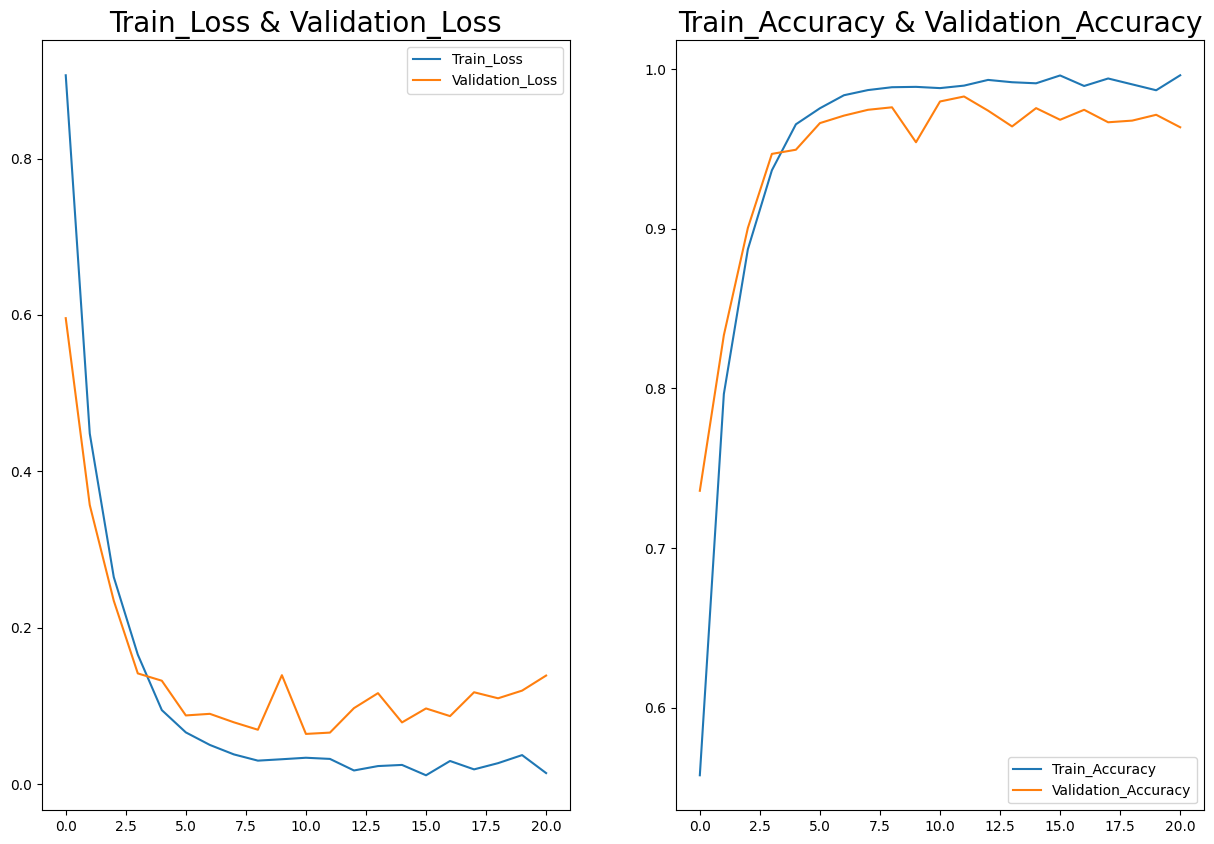

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [13]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 1s 13ms/step - loss: 0.0823 - accuracy: 0.9755
Test Loss = 0.08230727165937424
Test Accuracy = 0.9755208492279053


In [14]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 1s 13ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,2,2
4,2,2
...,...,...
1915,2,2
1916,0,0
1917,2,2
1918,3,3


array([[479,   0,   1,   0],
       [  0, 480,   0,   0],
       [  2,   0, 453,  25],
       [  1,   0,  18, 461]], dtype=int64)

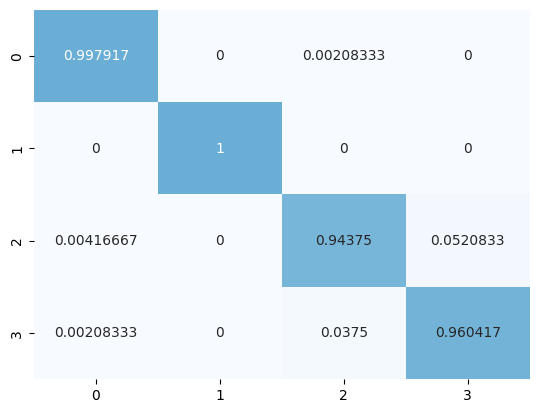

In [15]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [16]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      1.00       480
           1       1.00      1.00      1.00       480
           2       0.96      0.94      0.95       480
           3       0.95      0.96      0.95       480

    accuracy                           0.98      1920
   macro avg       0.98      0.98      0.98      1920
weighted avg       0.98      0.98      0.98      1920



In [18]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define function to prepare image
def prepare_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load the image
    img_array = img_to_array(img)  # Convert the image to numpy array
    img_array = img_array / 255.0  # Scale the image (if your model requires normalization)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load saved models
models = []
for i in range(1, 4):
    model_path = f"model_{i}.h5"
    model = keras.models.load_model(model_path)
    models.append(model)

# Define image path
image_path = "Alzheimer_s Dataset/test/NonDemented/26 (100).jpg"

# Prepare the image
prepared_image = prepare_image(image_path, target_size=(176, 176))

# Predict using each model
predictions = [model.predict(prepared_image) for model in models]

# Combine predictions
ensemble_prediction = np.mean(predictions, axis=0)
predicted_class = np.argmax(ensemble_prediction, axis=1)  # Get the class with highest probability

# Output the result
class_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
predicted_class_label = class_labels[predicted_class[0]]
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 0s 84ms/step
Predicted Class: NonDemented


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imutils import paths

In [3]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label: index for index, label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self, index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index
    
    def __len__(self):
        return len(self.paths)
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [4]:

# Define the transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load your train and test paths
train_paths = list(paths.list_images('train'))
test_paths = list(paths.list_images('test'))
-
# Debug: Check if paths are loaded correctly
print(f'Number of training images: {len(train_paths)}')
print(f'Number of testing images: {len(test_paths)}')

Number of training images: 5121
Number of testing images: 1279


In [5]:
# Instantiate the datasets
train_dataset = CustomDataset(train_paths, transform=train_transform)

# Split the test dataset into validation and test datasets
val_paths, test_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

# Balance the train dataset
def balance_dataset(paths, labels):
    ros = RandomOverSampler(random_state=42)
    paths, labels = ros.fit_resample(np.array(paths).reshape(-1, 1), labels)
    return paths.flatten().tolist(), labels

# Get labels for train dataset
train_labels = [train_dataset.get_label(path) for path in train_paths]
train_paths_balanced, train_labels_balanced = balance_dataset(train_paths, train_labels)

# Create the balanced train dataset
train_dataset_balanced = CustomDataset(train_paths_balanced, transform=train_transform)

# Create the validation and test datasets
val_dataset = CustomDataset(val_paths, transform=test_transform)
test_dataset = CustomDataset(test_paths, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset_balanced, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the balance of the train dataset
train_labels_balanced_check = [train_dataset_balanced.get_label(path) for path in train_dataset_balanced.paths]
print('Balanced Training Class labels:', np.unique(train_labels_balanced_check, return_counts=True))


Balanced Training Class labels: (array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16'), array([2560, 2560, 2560, 2560], dtype=int64))


In [6]:
# Model definition
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)


In [7]:
# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 5  # Number of classes
model = MobileNetModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


C:\Users\085\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\085\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\085\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:

# Training and evaluation functions
def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data, labels = batch
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 25
tolerance = 0

print("Starting training...")

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)
    scheduler.step(val_loss)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "mobilenet_1.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

Starting training...
Epoch 1: Train Loss: 0.7876, Train Acc: 64.30%, Val Loss: 5.0639, Val Acc: 18.62%
Epoch 2: Train Loss: 0.5882, Train Acc: 74.09%, Val Loss: 5.4949, Val Acc: 23.16%
Epoch 3: Train Loss: 0.4926, Train Acc: 78.86%, Val Loss: 6.1383, Val Acc: 33.33%
Epoch 4: Train Loss: 0.4298, Train Acc: 82.14%, Val Loss: 5.8396, Val Acc: 37.72%
Epoch 5: Train Loss: 0.3796, Train Acc: 84.04%, Val Loss: 5.8517, Val Acc: 30.83%
Epoch 6: Train Loss: 0.2782, Train Acc: 88.65%, Val Loss: 5.9621, Val Acc: 37.72%
Epoch 7: Train Loss: 0.2563, Train Acc: 89.65%, Val Loss: 6.4965, Val Acc: 32.39%
Epoch 8: Train Loss: 0.2322, Train Acc: 90.85%, Val Loss: 6.6671, Val Acc: 33.18%


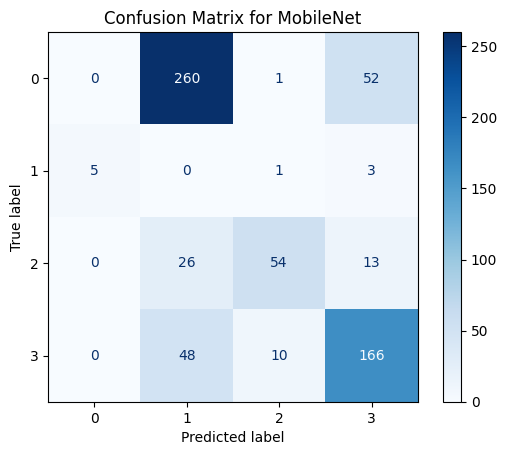

In [9]:
# Generate predictions and true labels for confusion matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data, labels = batch
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MobileNet")
plt.show()

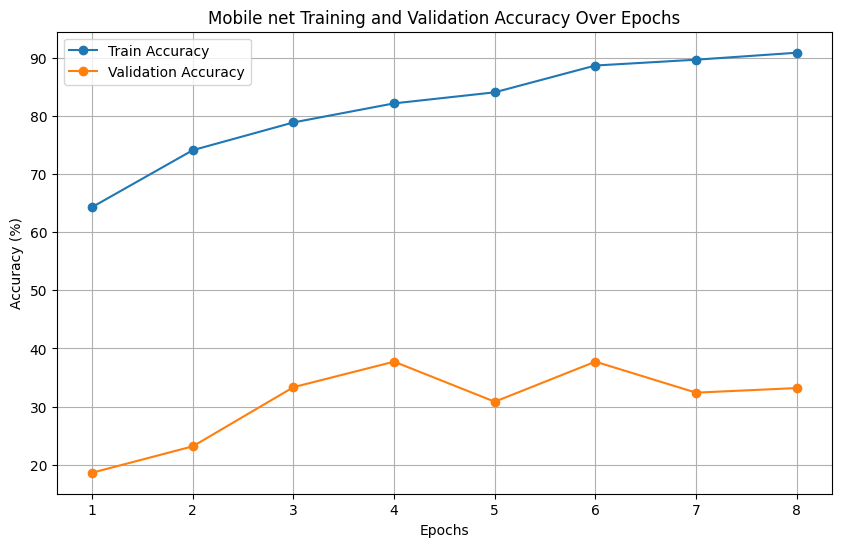

In [1]:
import matplotlib.pyplot as plt

# Values from the user's training and validation process
epochs = [1, 2, 3, 4, 5, 6, 7, 8]
train_acc = [64.30, 74.09, 78.86, 82.14, 84.04, 88.65, 89.65, 90.85]
val_acc = [18.62, 23.16, 33.33, 37.72, 30.83, 37.72, 32.39, 33.18]

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Mobile net Training and Validation Accuracy Over Epochs")
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


C:\Users\085\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\085\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\085/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 21.9MB/s]
C:\Users\085\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is de

Epoch 1: Train Loss: 0.8356, Train Acc: 62.59%, Val Loss: 4.3111, Val Acc: 32.71%
Epoch 2: Train Loss: 0.5756, Train Acc: 74.72%, Val Loss: 4.1572, Val Acc: 20.34%
Epoch 3: Train Loss: 0.4702, Train Acc: 80.06%, Val Loss: 4.2613, Val Acc: 20.81%
Epoch 4: Train Loss: 0.3968, Train Acc: 83.56%, Val Loss: 4.9845, Val Acc: 31.46%
Epoch 5: Train Loss: 0.3509, Train Acc: 85.69%, Val Loss: 5.3039, Val Acc: 32.24%
Epoch 6: Train Loss: 0.3109, Train Acc: 87.41%, Val Loss: 4.1207, Val Acc: 34.90%
Epoch 7: Train Loss: 0.2793, Train Acc: 88.94%, Val Loss: 7.9166, Val Acc: 15.65%
Epoch 8: Train Loss: 0.2667, Train Acc: 89.50%, Val Loss: 8.5215, Val Acc: 27.23%
Epoch 9: Train Loss: 0.2359, Train Acc: 90.63%, Val Loss: 5.3252, Val Acc: 40.06%
Epoch 10: Train Loss: 0.2267, Train Acc: 90.99%, Val Loss: 5.5570, Val Acc: 37.87%
Epoch 11: Train Loss: 0.2216, Train Acc: 91.32%, Val Loss: 6.1052, Val Acc: 39.59%
Epoch 12: Train Loss: 0.1532, Train Acc: 93.86%, Val Loss: 6.3416, Val Acc: 39.75%
Epoch 13: Tra

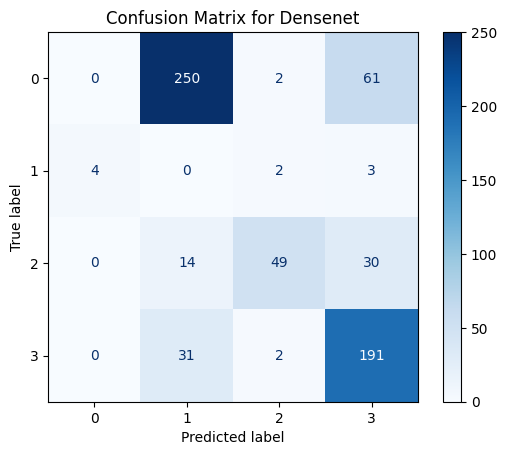

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model definition with dropout
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 30
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model()

    # Step the scheduler
    scheduler.step(val_loss)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "densenet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Densenet")
plt.show()


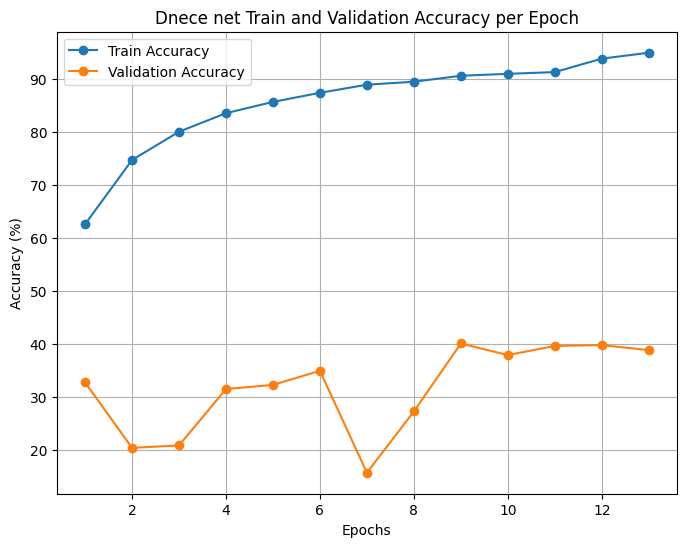

In [2]:
import matplotlib.pyplot as plt

# Data for epochs, train accuracy, and validation accuracy
epochs = list(range(1, 14))
train_acc = [62.59, 74.72, 80.06, 83.56, 85.69, 87.41, 88.94, 89.50, 90.63, 90.99, 91.32, 93.86, 94.98]
val_acc = [32.71, 20.34, 20.81, 31.46, 32.24, 34.90, 15.65, 27.23, 40.06, 37.87, 39.59, 39.75, 38.81]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Dnece net Train and Validation Accuracy per Epoch')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()
